# Epileptic Seizure Type Prediction
This project focuses on predicting epileptic seizures using EEG data from the [BEED: Bangalore EEG Epilepsy Dataset](https://archive.ics.uci.edu/dataset/1134/beed:+bangalore+eeg+epilepsy+dataset). I want to use this dataset to develop a supervised learning model that can predict __seizure occurring types__ based on the EEG signals. The project employs several supervised learning techniques to predict seizure types.   
In this notebook, I will do the following analysis:
1. Explore the dataset - BEED dataset.  
2. Explore feature selection methods to identify the most relevant features for prediction. The performance of the model will be evaluated using metrics such as accuracy, precision, recall, and F1-score.  
3. Try to use LogisticRegression, Support Vector Classifier (SVC) and Extra Trees Classifier as the main prediction algorithm.   
4. Hyperparameter tuning using GridSearchCV to optimize the model's performance.
5. Analyze the results and discuss the findings.


# Dataset Overview
The dataset contains EEG recordings from patients with epilepsy, and my goal is to build a machine learning model that can predict seizure events. The dataset consists of EEG recordings from UI Irvine ML Repository. The data recorded at a neurological research centre in Bangalore, India and was gathered using the standard 10-20 electrode system at a sampling rate of 256 Hz.    

It has __8000 records__ and contains 16,000 segments of 20-second EEG recordings evenly distributed across four categories: Healthy Subjects (0), Generalized Seizures (1), Focal Seizures (2), and Seizure Events (3). Each category includes data from **20 adult** subjects (ages 21-55) with equal gender representation.  
The csv file includes __16 EEG channels (X1-X16) which corresponding to different brain regions(16 features) and 1 target variable which refers to 4 categories__, indicating the type of seizure event. We can use these features to predict the seizure types.  
<br> 
**Data Structure(Refer to the dataset documentation):**
1. It has 8000 rows and 17 columns.
2. Each row represents a 20-second EEG recording segment.
3. 80 individuals (each type has 20 individuals)
4. 200 segments per individual
5. 16 features representing EEG signal channel
6. 1 target variable indicating the type of seizure event.
   - 3 Recording of seizure events (including activities such as eye blinking or constant staring)
   - 2 Recording of focal seizures
   - 1 Recording of generalized seizures
   - 0 Recording of healthy subjects (control group without epileptic seizures)

**Dataset Source:**   
BEED: Bangalore EEG Epilepsy Dataset. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/1134/beed:+bangalore+eeg+epilepsy+dataset  

In [116]:
## Import all library
import warnings
warnings.filterwarnings('ignore')

import pathlib as pl # for library path
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np

# statistic
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# hyper tuning and feature selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
# training model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC


In [117]:
# load data
df = pd.read_csv('BEED_Data.csv') # it includes 17 columns(16 features and 1 target variable) 
print(f'There are {len(df)} rows in the dataset.')
df.head()

There are 8000 rows in the dataset.


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,y
0,4,7,18,25,28,27,20,10,-10,-18,-20,-16,13,32,12,10,0
1,87,114,120,106,76,54,28,5,-19,-49,-85,-102,-100,-89,-61,-21,0
2,-131,-133,-140,-131,-123,-108,-58,-51,-70,-77,-76,-76,-73,-57,-40,-14,0
3,68,104,73,34,-12,-26,-38,-36,-67,-88,-25,31,18,-4,6,-29,0
4,-67,-90,-97,-94,-86,-71,-43,-11,23,46,58,50,39,19,-9,-41,0


# Data Cleaning
Load the dataset and check for missing values or inconsistencies. Although the dataset has been preprocessed and the dataset didn’t require further cleaning, it is still a good habit to check and clean the data.


In [118]:
# check null value
null_sum = df.isnull().sum()
print(f'Null value count: ')
null_sum

Null value count: 


X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
y      0
dtype: int64

In [68]:
# check labels are all in [0, 1, 2, 3]
df['y'].value_counts()

y
0    2000
1    2000
2    2000
3    2000
Name: count, dtype: int64

In [69]:
# check if there are any outer value
channels = [f'X{i}' for i in range(1,17)]
df[channels].agg(['min','max']) 

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
min,-281,-255,-255,-257,-264,-277,-277,-260,-290,-302,-276,-306,-288,-290,-323,-317
max,252,261,238,246,249,245,220,271,280,251,262,283,296,291,251,270


# Exploratory Data Analysis (EDA)
Now, let's perform some exploratory data analysis (EDA) to understand the dataset better. We will understand the relationships between features and the target variable and visualize the distribution of seizure types and EEG signal patterns using plots.

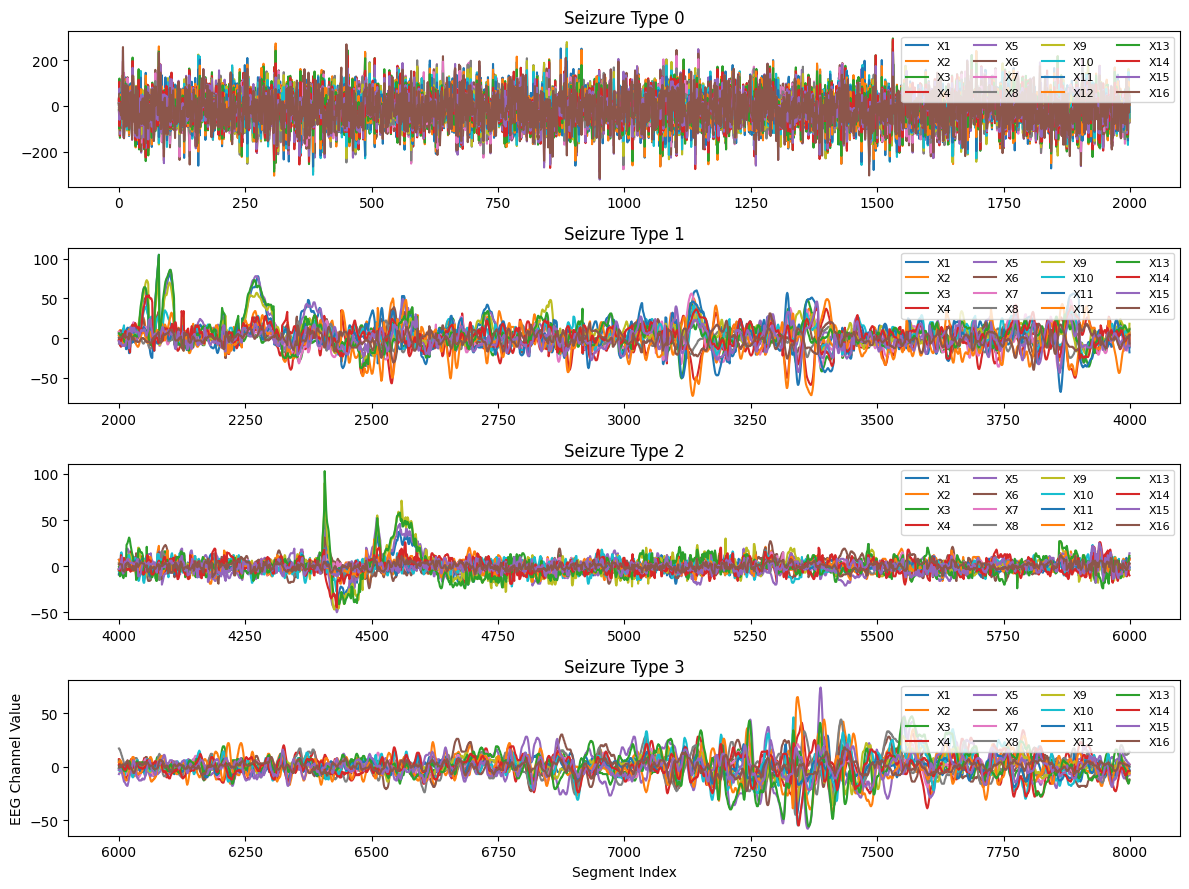

In [70]:
# visualize eeg data accrodding to each types
df_type0 = df.iloc[0:2000, :]  
df_type1 = df.iloc[2000:4000, :]  
df_type2 = df.iloc[4000:6000, :]  
df_type3 = df.iloc[6000:8000, :]  

channels = [f'X{i}' for i in range(1,17)]
seizure_types = [0,1,2,3]

fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=False)

for i, seizure_type in enumerate(seizure_types):
    start = i * 2000
    end = (i + 1) * 2000
    subset = df.iloc[start: end, :]
    if subset.empty:
        continue
    for ch in channels:
        axs[i].plot(subset.index, subset[ch], label=ch)
    axs[i].set_title(f'Seizure Type {seizure_type}')
    axs[i].legend(loc='upper right', ncol=4, fontsize=8)

plt.xlabel('Segment Index')
plt.ylabel('EEG Channel Value')
plt.tight_layout()
plt.show()

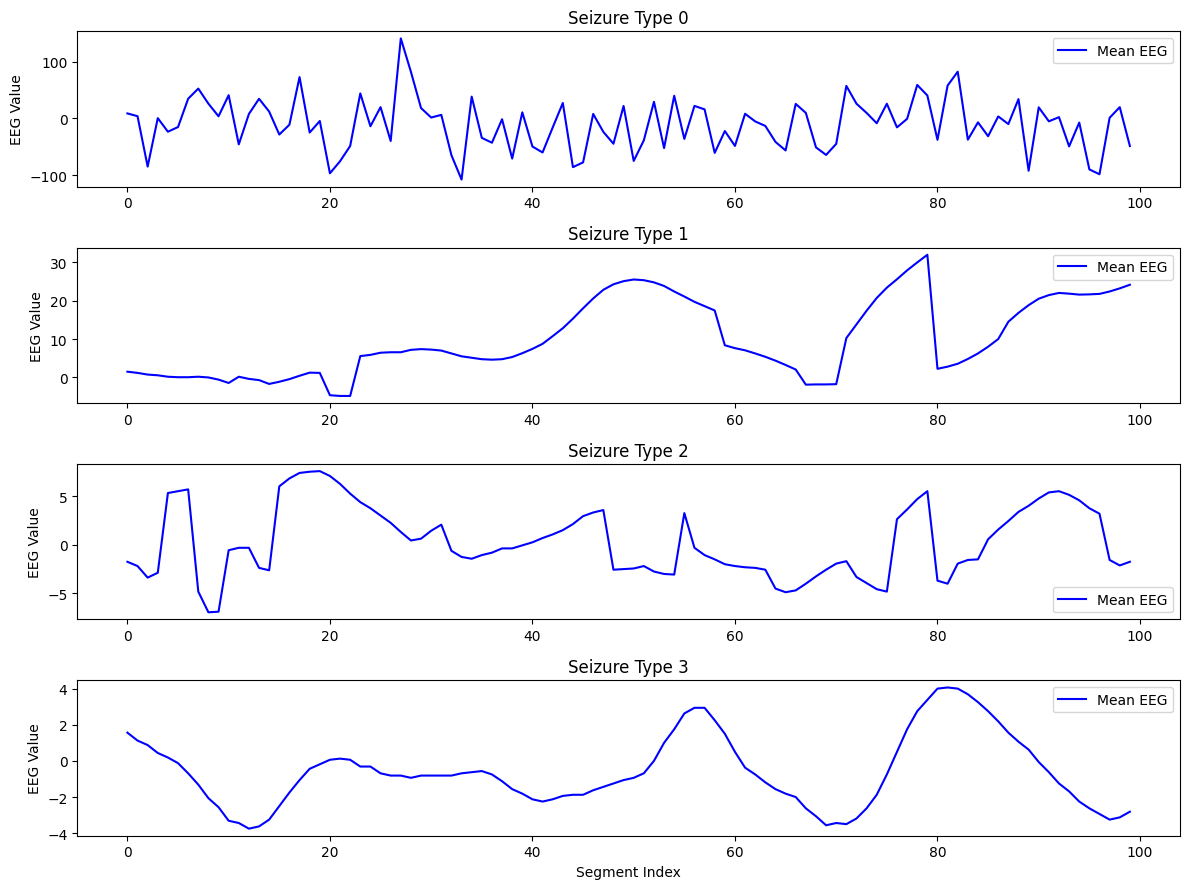

In [71]:
# visualize eeg data channels mean accrodding to patients (one patient per type)
patient_df = df.iloc[:100, :]
fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=False)

for i, st in enumerate(seizure_types):
    start = i * 2000
    end = start + 100
    subset = df.iloc[start: end, :]
    if subset.empty:
        axs[i].set_title(f'Seizure Type {st} (No Data)')
        continue
    mean_signal = subset[channels].mean(axis=1)
    axs[i].plot(range(0, 100), mean_signal, color='blue', label='Mean EEG')
    axs[i].set_title(f'Seizure Type {st}')
    axs[i].set_ylabel('EEG Value')
    axs[i].legend()

plt.xlabel('Segment Index')
plt.tight_layout()
plt.show()

## Statistical Analysis of EEG Features

In [103]:
# Statistical summary by seizure type
print('=== Statistical Summary by Seizure Type ===')
for seizure_type in seizure_types:
    start_idx = seizure_type * 2000
    end_idx = (seizure_type + 1) * 2000
    subset = df.iloc[start_idx:end_idx, :]
    
    print(f'\nSeizure Type {seizure_type}:')
    print(f'{"Channel":<8} {"Mean":<8} {"Std":<8} {"Min":<8} {"Max":<8}')
    print('-' * 45)
    
    for channel in channels:
        channel_data = subset[channel]
        mean_val = channel_data.mean()
        std_val = channel_data.std()
        min_val = channel_data.min()
        max_val = channel_data.max()
        
        print(f'{channel:<8} {mean_val:<8.2f} {std_val:<8.2f} {min_val:<8.2f} {max_val:<8.2f}')
    
    print('-' * 50)

=== Statistical Summary by Seizure Type ===

Seizure Type 0:
Channel  Mean     Std      Min      Max     
---------------------------------------------
X1       -12.86   68.96    -281.00  252.00  
X2       -12.33   69.17    -255.00  261.00  
X3       -12.23   69.10    -255.00  238.00  
X4       -12.30   69.00    -257.00  246.00  
X5       -12.47   69.03    -264.00  249.00  
X6       -12.23   69.72    -277.00  245.00  
X7       -12.27   70.10    -277.00  220.00  
X8       -12.59   70.85    -260.00  271.00  
X9       -13.35   71.54    -290.00  280.00  
X10      -13.63   71.67    -302.00  251.00  
X11      -13.70   70.98    -276.00  262.00  
X12      -13.87   70.28    -306.00  283.00  
X13      -14.37   69.85    -288.00  296.00  
X14      -14.74   69.55    -290.00  291.00  
X15      -14.73   69.66    -323.00  251.00  
X16      -14.83   69.96    -317.00  270.00  
--------------------------------------------------

Seizure Type 1:
Channel  Mean     Std      Min      Max     
---------------

## Statistical Testing for Group Differences

In [101]:
# Statistical significance testing between groups
print('=== Statistical Testing for Group Differences ===')

# Test for significant differences across seizure types for each channel
significant_channels = []

for channel in channels:
    # Extract data for each seizure type
    groups = []
    for seizure_type in seizure_types:
        start_idx = seizure_type * 2000
        end_idx = (seizure_type + 1) * 2000
        subset = df.iloc[start_idx:end_idx, :]
        groups.append(subset[channel])
    
    f_stat, p_value = stats.f_oneway(*groups)
    
    if p_value < 0.05:
        significant_channels.append(channel)
        print(f'{channel}: F-statistic = {f_stat:.3f}, p-value = {p_value:.3e} (SIGNIFICANT)')
    else:
        print(f'{channel}: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}')

print(f'\nChannels with significant differences between seizure types: {significant_channels}')
print(f'Total significant channels: {len(significant_channels)} out of {len(channels)}')

# eta-squared
print('\n=== Effect Size Analysis (Eta-squared) ===')
for channel in significant_channels[:5]:  # Show top 5 for brevity
    groups = []
    for seizure_type in seizure_types:
        start_idx = seizure_type * 2000
        end_idx = (seizure_type + 1) * 2000
        subset = df.iloc[start_idx:end_idx, :]
        groups.append(subset[channel])
    
    # Calculate eta-squared (effect size)
    f_stat, p_value = stats.f_oneway(*groups)
    # SS_between / SS_total approximation
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)
    
    ss_between = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in groups)
    ss_total = sum((all_data - grand_mean)**2)
    eta_squared = ss_between / ss_total
    
    print(f"{channel}: η² = {eta_squared:.3f} ({'Large' if eta_squared > 0.14 else 'Medium' if eta_squared > 0.06 else 'Small'} effect)")

=== Statistical Testing for Group Differences ===
X1: F-statistic = 105.942, p-value = 2.932e-67 (SIGNIFICANT)
X2: F-statistic = 76.877, p-value = 5.089e-49 (SIGNIFICANT)
X3: F-statistic = 57.400, p-value = 1.052e-36 (SIGNIFICANT)
X4: F-statistic = 50.306, p-value = 3.345e-32 (SIGNIFICANT)
X5: F-statistic = 87.202, p-value = 1.615e-55 (SIGNIFICANT)
X6: F-statistic = 70.327, p-value = 6.930e-45 (SIGNIFICANT)
X7: F-statistic = 54.223, p-value = 1.090e-34 (SIGNIFICANT)
X8: F-statistic = 56.994, p-value = 1.902e-36 (SIGNIFICANT)
X9: F-statistic = 100.722, p-value = 5.376e-64 (SIGNIFICANT)
X10: F-statistic = 84.886, p-value = 4.612e-54 (SIGNIFICANT)
X11: F-statistic = 67.741, p-value = 2.983e-43 (SIGNIFICANT)
X12: F-statistic = 60.427, p-value = 1.270e-38 (SIGNIFICANT)
X13: F-statistic = 104.087, p-value = 4.227e-66 (SIGNIFICANT)
X14: F-statistic = 101.372, p-value = 2.108e-64 (SIGNIFICANT)
X15: F-statistic = 75.528, p-value = 3.612e-48 (SIGNIFICANT)
X16: F-statistic = 82.385, p-value = 1.7

## EDA Summary and Insights

Based on the exploratory data analysis, we can summarize the following key findings:
1. **Seizure Type Distribution:** The dataset contains a balanced distribution of seizure types, which is crucial for training robust models.
2. **Representative Channels:** There are significant differences in EEG signal characteristics across seizure types depending on the chart. 
3. **Statistical Significance:** Most of the EEG channels show statistically significant differences between seizure types, indicating their potential importance for classification. 

These insights inform our feature selection and model development strategies in the subsequent analysis.

# Prepare data
- Split the dataset into training and testing sets.


In [ ]:
# split data using stratified patient-based splitting to avoid data overlapping
X = df[channels].values
y = df['y'].values

# Class 0: 0-19, Class 1: 20-39, Class 2: 40-59, Class 3: 60-79
patient_ids = np.repeat(range(80), 100) # 100 rows is a group signal for 1 person

np.random.seed(42)  # For reproducibility

train_idx = []
test_idx = []

for class_id in range(4):
    # Get patient IDs for this class
    class_patients = list(range(class_id * 20, (class_id + 1) * 20))
    
    # 8000 rows
    # each type has 2000 rows for 20 patients => 100 rows/person => signal group
    # I randomly select 4 group signals for test, 16 group signals for train
    test_patients = np.random.choice(class_patients, size=4, replace=False)
    train_patients = [p for p in class_patients if p not in test_patients]
    
    print(f'Class {class_id}: Test patients {sorted(test_patients)}, Train patients {sorted(train_patients)}')
    
    for patient_id in test_patients:
        sample_start = patient_id * 100
        sample_end = (patient_id + 1) * 100
        test_idx.extend(range(sample_start, sample_end))
    
    for patient_id in train_patients:
        sample_start = patient_id * 100
        sample_end = (patient_id + 1) * 100
        train_idx.extend(range(sample_start, sample_end))

train_idx = np.array(train_idx)
test_idx = np.array(test_idx)

# Split the data based on the indices
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

Class 0: Test patients [np.int64(0), np.int64(1), np.int64(15), np.int64(17)], Train patients [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19]
Class 1: Test patients [np.int64(25), np.int64(35), np.int64(36), np.int64(39)], Train patients [20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38]
Class 2: Test patients [np.int64(40), np.int64(42), np.int64(47), np.int64(50)], Train patients [41, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Class 3: Test patients [np.int64(60), np.int64(66), np.int64(68), np.int64(78)], Train patients [61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79]



# Feature Engineering
- Feature scaling using StandardScaler
- Feature selection using Recursive Feature Elimination (RFE)


In [78]:
# data standardized
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
lr = LogisticRegression(random_state=42, penalty='l2')
rfecv = RFECV(
    estimator=lr,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy'
)

rfecv.fit(X_train, y_train)

print('LogisticRegression RFECV')
print('Optimal number of features:', rfecv.n_features_)
print('Selected features:', rfecv.support_)
print('Ranking: ', rfecv.ranking_)

feature_names = [f'X{i+1}' for i in range(X.shape[1])]

top_features_lr = []
for i in range(X.shape[1]):
    if rfecv.support_[i] == True:
        top_features_lr.append(f'X{i+1}')

print('Selected features:', list(top_features_lr))

LogisticRegression RFECV
Optimal number of features: 9
Selected features: [False  True False  True  True False  True False  True  True  True False
 False  True  True False]
Ranking:  [8 1 3 1 1 2 1 7 1 1 1 4 5 1 1 6]
Selected features: ['X2', 'X4', 'X5', 'X7', 'X9', 'X10', 'X11', 'X14', 'X15']


In [80]:
svc = SVC(kernel='linear')
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy'
)

rfecv.fit(X_train, y_train)

print('SVC RFECV')
print('Optimal number of features:', rfecv.n_features_)
print('Selected features:', rfecv.support_)
print('Ranking: ', rfecv.ranking_)

feature_names = [f'X{i+1}' for i in range(X.shape[1])]

top_features_svc = []
for i in range(X.shape[1]):
    if rfecv.support_[i] == True:
        top_features_svc.append(f'X{i+1}')

print('Selected features:', list(top_features_svc))

SVC RFECV
Optimal number of features: 9
Selected features: [False  True  True  True  True False False False False  True  True False
 False  True  True  True]
Ranking:  [5 1 1 1 1 2 7 4 6 1 1 3 8 1 1 1]
Selected features: ['X2', 'X3', 'X4', 'X5', 'X10', 'X11', 'X14', 'X15', 'X16']


In [81]:
etc = ExtraTreesClassifier(n_estimators=200, random_state=42)
rfecv = RFECV(
    estimator=etc,
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy'
)

rfecv.fit(X_train, y_train)

print('ExtraTreesClassifier RFECV')
print('Optimal number of features:', rfecv.n_features_)
print('Selected features:', rfecv.support_)
print('Ranking: ', rfecv.ranking_)

feature_names = [f'X{i+1}' for i in range(X.shape[1])]

top_features_etc = []
for i in range(X.shape[1]):
    if rfecv.support_[i] == True:
        top_features_etc.append(f'X{i+1}')

print('Selected features:', list(top_features_etc))

ExtraTreesClassifier RFECV
Optimal number of features: 15
Selected features: [ True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True]
Ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1]
Selected features: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X14', 'X15', 'X16']



# Model Selection and Training
- Train multiple classification models (e.g., Logistic Regression, SVC, ExtraTreesClassifier, SVC).
- Use evaluation metrics such as accuracy, precision, recall, and F1-score to compare model performance.


## Traing without Feature Selection

LogisticRegression Report:

              precision    recall  f1-score   support

           0       0.99      0.49      0.66       400
           1       0.45      0.46      0.45       400
           2       0.30      0.45      0.36       400
           3       0.15      0.15      0.15       400

    accuracy                           0.39      1600
   macro avg       0.47      0.39      0.41      1600
weighted avg       0.47      0.39      0.41      1600



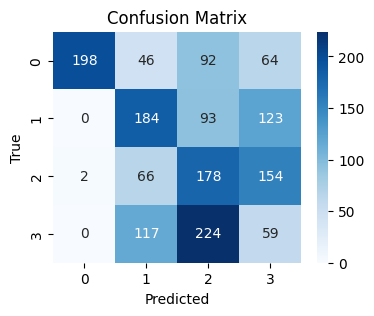

In [105]:
# LogisticRegression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('LogisticRegression Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

SVC Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.77      0.61      0.68       400
           2       0.50      0.94      0.66       400
           3       0.50      0.17      0.26       400

    accuracy                           0.68      1600
   macro avg       0.69      0.68      0.65      1600
weighted avg       0.69      0.68      0.65      1600



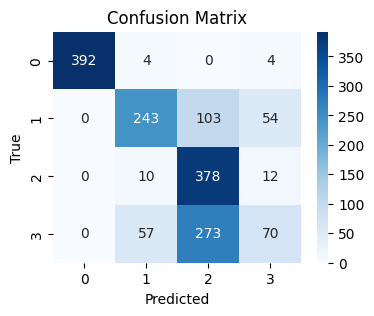

In [106]:
# SVC
svc = SVC(probability=True, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('SVC Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


ExtraTreesClassifier Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.85      0.89      0.87       400
           2       0.67      0.91      0.77       400
           3       0.81      0.48      0.61       400

    accuracy                           0.82      1600
   macro avg       0.83      0.82      0.81      1600
weighted avg       0.83      0.82      0.81      1600



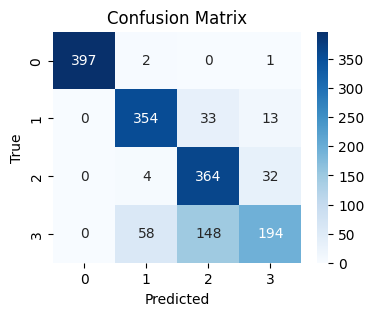

In [107]:
# ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

print('ExtraTreesClassifier Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Traing with Feature Selection
In the following section, I trained model with the feature selections that I got from the previous section - Feature Engineering.  
However, we found that the model performance is not improved after feature selection. The accuracy of the models decreased slightly when using the selected features compared to using all features.

LogisticRegression Report:

              precision    recall  f1-score   support

           0       0.89      0.48      0.62       400
           1       0.41      0.43      0.42       400
           2       0.28      0.35      0.32       400
           3       0.19      0.23      0.21       400

    accuracy                           0.37      1600
   macro avg       0.44      0.37      0.39      1600
weighted avg       0.44      0.37      0.39      1600



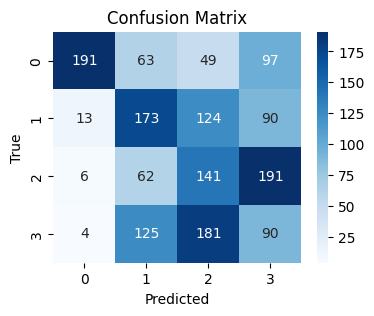

[[191  63  49  97]
 [ 13 173 124  90]
 [  6  62 141 191]
 [  4 125 181  90]]


In [115]:
# LogisticRegression
cols_to_select_indices = [feature_names.index(c) for c in top_features_lr]

X_train_new = X_train[:, cols_to_select_indices]
X_test_new = X_test[:, cols_to_select_indices]

clf = LogisticRegression(random_state=42)
clf.fit(X_train_new, y_train)
y_pred = clf.predict(X_test_new)

print('LogisticRegression Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(cm)


SVC Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       400
           1       0.76      0.54      0.63       400
           2       0.47      0.94      0.62       400
           3       0.34      0.10      0.16       400

    accuracy                           0.64      1600
   macro avg       0.64      0.64      0.60      1600
weighted avg       0.64      0.64      0.60      1600



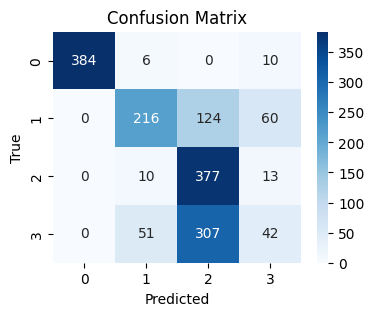

[[384   6   0  10]
 [  0 216 124  60]
 [  0  10 377  13]
 [  0  51 307  42]]


In [114]:
# SVC
cols_to_select_indices = [feature_names.index(c) for c in top_features_svc]

X_train_new = X_train[:, cols_to_select_indices]
X_test_new = X_test[:, cols_to_select_indices]

svc = SVC(probability=True, kernel='rbf')
svc.fit(X_train_new, y_train)
y_pred = svc.predict(X_test_new)

print('SVC Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(cm)


ExtraTreesClassifier Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.86      0.88      0.87       400
           2       0.65      0.88      0.75       400
           3       0.76      0.48      0.59       400

    accuracy                           0.81      1600
   macro avg       0.82      0.81      0.80      1600
weighted avg       0.82      0.81      0.80      1600



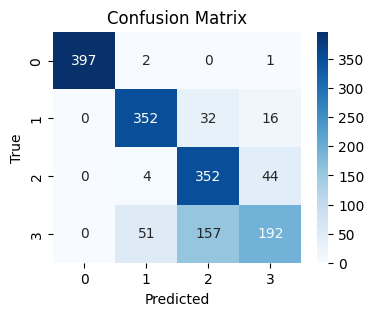

[[397   2   0   1]
 [  0 352  32  16]
 [  0   4 352  44]
 [  0  51 157 192]]


In [113]:
# ExtraTreesClassifier
cols_to_select_indices = [feature_names.index(c) for c in top_features_etc]

X_train_new = X_train[:, cols_to_select_indices]
X_test_new = X_test[:, cols_to_select_indices]

etc = ExtraTreesClassifier(n_estimators=200, random_state=42)
etc.fit(X_train_new, y_train)
y_pred = etc.predict(X_test_new)

print('ExtraTreesClassifier Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(cm)



# Hyperparameter Tuning
- Perform hyperparameter tuning using GridSearchCV to optimize model performance.


In [88]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=etc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Best Params:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Params: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.7735937500000001


ExtraTreesClassifier Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.86      0.89      0.87       400
           2       0.70      0.88      0.78       400
           3       0.77      0.55      0.64       400

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.82      1600
weighted avg       0.83      0.83      0.82      1600



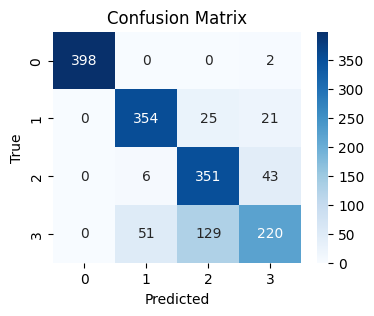

[[398   0   0   2]
 [  0 354  25  21]
 [  0   6 351  43]
 [  0  51 129 220]]


In [112]:
# ExtraTreesClassifier
cols_to_select_indices = [feature_names.index(c) for c in top_features_etc]

X_train_new = X_train[:, cols_to_select_indices]
X_test_new = X_test[:, cols_to_select_indices]

etc = ExtraTreesClassifier(n_estimators=300, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5)
etc.fit(X_train_new, y_train)
y_pred = etc.predict(X_test_new)

print('ExtraTreesClassifier Report:\n')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(cm)



# Model Evaluation
- Evaluate the best model using metrics such as accuracy, precision, recall, F1-score.
- Analyze the confusion matrix to understand misprediction.

## Final Model and Results
Based on the training model results, I found that in this dataset, the model without feature selection performed better than the model with feature selection. This could be because all features in this dataset are significant for prediction, and removing any feature may lead to loss of important information.

| Model | Precision | Recall | F1-Score |
|--- |  --- | --- | --- |
| Logistic Regression | 0.47 | 0.39 | 0.41 |
| SVC | 0.69 | 0.68 | 0.65 |
| ExtraTreesClassifier | 0.83 | 0.82 | 0.81 |

** all models results in the table are trained without feature selection.   

And I chose **ExtraTreesClassifier** as the final model for epileptic seizure type prediction because it has highest performance across all metrics.
**ExtraTreesClassifier after hyperparameter tuning performed the best among the three models, achieving the highest precision, recall, and F1-score.**
| Model | Macro Precision | Macro Recall | Macro F1-Score |
|--- |  --- | --- | --- |
| ExtraTreesClassifier | 0.83 | 0.83 | 0.82 |

### Logistic Regression
Because Logistic Regression is a linear model, it may struggle to capture the complex patterns in EEG data, which can lead to lower performance. The model's simplicity might not be sufficient to differentiate between the nuanced features of different seizure types.  

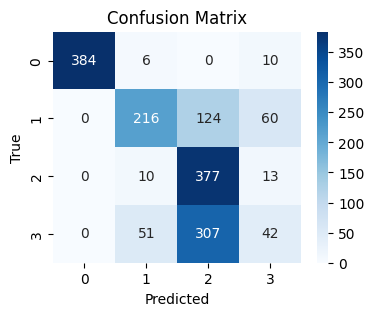

We can see that the confusion matrix indicates that the model has difficulty distinguishing between seizure type 1, 2, 3, leading to misprediction. This could be due to the feature between type 1, 2, 3 being quite similar, making it challenging for a linear model to separate them effectively. 
We need to consider more complex models or feature engineering techniques to improve prediction performance.

### SVC 
SVC performed better than Logistic Regression, likely due to its ability to handle non-linear decision boundaries. The RBF kernel allows SVC to capture more complex relationships in the data, which is beneficial for EEG signal prediction. However, it still may not fully capture all the intricacies of the EEG data, leading to moderate performance.  

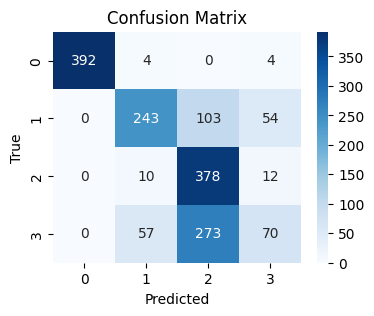

The confusion matrix shows that while SVC improves prediction accuracy, there are still misprediction between seizure types 1, 2 and 3. Especially there still are 223 type 3 samples that are predicted as type2. This suggests that while SVC is more capable than Logistic Regression, it may still struggle with the overlapping features of these seizure types.   

We may need to explore more advanced models or additional feature engineering techniques to further enhance prediction accuracy. Like adding features that capture temporal dynamics of EEG signals, using ensemble methods or using tree-based models so that we can learn more complex decision boundaries.

### ExtraTreesClassifier
ExtraTreesClassifier achieved the highest performance, likely due to its ensemble nature and ability to capture complex interactions between features. The model's robustness to noise and its capability to handle high-dimensional data make it well-suited for EEG signal prediction. The use of multiple trees helps in reducing overfitting and improving generalization to unseen data.   

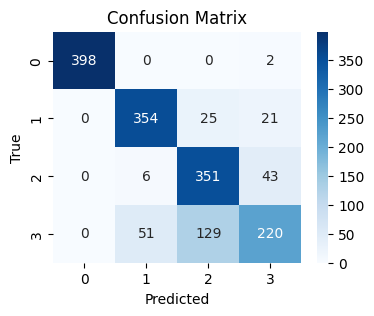

The confusion matrix indicates that ExtraTreesClassifier excels in accurately predicting all seizure types, with minimal misprediction. This suggests that the model effectively captures the distinct features of each seizure type, leading to superior prediction performance. If we want to make model better, we can also try the ensemble approach which allows the model to leverage the strengths of multiple decision trees, resulting in a more comprehensive understanding of the data.  

However, it's important to note that while ExtraTreesClassifier performed exceptionally well on this dataset, its performance may vary with different datasets or configurations. 
Further validation and testing on independent datasets would be necessary to confirm its effectiveness in broader applications.


# Conclusion
<div align='center'>

| Model | Precision | Recall | F1-Score |
|--- |  --- | --- | --- |
| Logistic Regression | 0.47 | 0.39 | 0.41 |
| SVC | 0.69 | 0.68 | 0.65 |
| ExtraTreesClassifier Hyper Tuning| 0.83 | 0.83 | 0.82 |

</div>

In this project, I successfully developed machine learning models to predict epileptic seizures using EEG data from the BEED dataset.  
The ExtraTreesClassifier emerged as the best-performing model, achieving 83% precision, recall, and 82% F1-score. This indicates that ensemble methods can effectively capture the complex patterns dataset, such as EEG signals, which are associated with different seizure types.

However, there are several areas for potential improvement and future work:
1. **Deep Learning Approaches:** Exploring deep learning models, such as Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs), could potentially give better performance by capturing temporal and spatial patterns in EEG data more effectively.
2. **Validation data:** It could have overfitting issue if the dataset is too small or too many features, if there are other dataset, it is recommended to check cross-validation scores or test set performance.
